# CS4500: Natural Language Processing Final Project

# Poetry Generation

Zach O'Brien

December, 2022




## 0. Set up Development Environment

 For additional info on virtual environments, see here: https://docs.python.org/3.9/tutorial/venv.html
 
**To run the code in this notebook, follow these steps.**

1. Install Python version 3.9.10, and use that version for the following steps
    - It's likely that this project will work with many different versions of Python, especially 3.9.x, but I include the version I worked with here just to be safe.
    <br />

2. Create a virtual environment

    ```shell
    python3 -m venv 4120_fp_obrien
    ```
    <br />
    
3. Activate the virtual environment

    ```shell
    # On windows:
    4120_fp_obrien\Scripts\activate.bat
    ```
     <br />
    
    ```shell
    # On Unix or MaxOS:
    source 4120_fp_obrien/bin/activate
    ```
     <br />
    
4. Install dependencies

    ```shell
    # With the 4120_fp_obrien virtual environment activated:
    python -m pip install -r requirements.txt
    ```
     <br />

5. Install this project's modular source code. **This step is CRITICAL**. If skipped, imports will not work.

    ```shell
    # With the 4120_fp_obrien virtual environment activated:
    cd src/
    python -m pip install -e .
    ```
     <br />
    
6. Verify the installation was succesful by running the unit test suite

    ```shell
    # In top-level project directory
    ./run_unit_tests.sh
    ```
    <br />

7. Finally, re-launch this notebook using the new virtual environment

    ```shell
    # With the 4120_fp_obrien virtual environment activated:
    jupyter lab
    ```

In [1]:
import itertools
import pickle
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import pad_sequence
from nltk.lm.preprocessing import flatten

from dataprep.parse_leaves_of_grass import leaves_of_grass_gutenberg_to_df
from dataprep.ngram_lm_preprocessing import preprocess_for_ngram_lm
from models.ngram_language_model import LanguageModel

## 1. Data Preparation

The raw data I used for this project was the complete text of Walt Whitman's "Leaves of Grass". To use it with NLP models, I had to parse out individual poems from the collection and then do some preprocessing on them.

### 1.1 Parse Raw Document

In [3]:
with open("data/leaves-of-grass.txt") as f:
    lines = f.readlines()

# I encapsulated the functionality of parsing the raw text into this function.
# It essentially segments on books, then poems.
poems = leaves_of_grass_gutenberg_to_df(lines)
poems.head(2)

,book_title,poem_title,poem
0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [4]:
poems["poem"][0]

'One’s-self I sing, a simple separate person,\n  Yet utter the word Democratic, the word En-Masse.\n\n  Of physiology from top to toe I sing,\n  Not physiognomy alone nor brain alone is worthy for the Muse, I say\n      the Form complete is worthier far,\n  The Female equally with the Male I sing.\n\n  Of Life immense in passion, pulse, and power,\n  Cheerful, for freest action form’d under the laws divine,\n  The Modern Man I sing.'

## 2. 3-gram Language Model

For this model I did not use a library. I used my own implementation of an n-gram language model from earlier inthe semester.

### 2.1 Prepare n-grams to give to the model

In [21]:
# To indicate the beginning and end of a poem
POEM_START_SYMBOL = "<p>"
POEM_END_SYMBOL = "</p>"

In [5]:
N_GRAM = 3

In [6]:
# Tokenize poems into words, but not sentences. Sentence and line breaks
# can have artistic meaning in poems, so I want their relationships to actual words
# to be preserved.
tokenized_poems = [preprocess_for_ngram_lm(p) for p in poems["poem"]]
padded_tokenized_poems = [list(pad_sequence(
                                poem,
                                pad_left=True, 
                                left_pad_symbol=POEM_START_SYMBOL,
                                pad_right=True,
                                right_pad_symbol=POEM_END_SYMBOL,
                                n=N_GRAM))
                          for poem in tokenized_poems]
    
tokens = list(flatten(padded_tokenized_poems))

print(f"There are {len(tokens)} tokens in the dataset. \n")
print(tokens[0:10])
print(tokens[-10:],)

There are 159020 tokens in the dataset. 

['<p>', '<p>', 'one', '’', 's-self', 'i', 'sing', ',', 'a', 'simple']
['good-bye', '--', 'and', 'hail', '!', 'my', 'fancy', '.', '</p>', '</p>']


### 2.2 Train the n-gram language model

In [7]:
ngram_model = LanguageModel(N_GRAM, is_laplace_smoothing=True)
ngram_model.train(tokens)

### 2.3 Generate a Poem

In [8]:
poem = ngram_model.generate_poem()
print((poem
       .replace("<p>", "")
       .replace("<UNK>", "")
       .replace("NEWLINE", "\n")
       .replace("<nl>", "\n")))

 o tan-faced  , 
 it was read here , 
 carrying what has the day and night , at least i know.

 is it night ? are we , even in the open air , 
 holding a tray , he is action and power  things , 
 her high-borne turban ’ d me , 
  , always  , my
 companions.

 o  ? 

 is to-day nothing ? 
 have you to confide to me with the rest , the house itself.

 belief i sing -- as if one could but fly like a child , 
 some of them , 
 the household wreck ’ d alone over the past -- having its long , 
 forever touching them or touch , and the  rise after rise bow the phantoms behind me states ! 
 shapes of the brawny and tall-topt city , 
 she ’ s place in the midst of the sea , and the victories of
 mighty  4
 muscle and pluck forever ! 
 continue your  face and worn brow , black , she  the moor , 
 and what shall i cease from thee -- the  of the baritone singer singing his
 sweet romanza , i sing.
 man ’ s kiss dwells on these bearded lips . )</p></p>


As you can see, a little bit of postprocessing is required. \<UNK> words should be removed, and NEWLINE should be replaced with \\n

## 3. LSTM Neural Network Language Model

The task of generating text can be framed as a timeseries task. Given a sequence of prior tokens, predict the probability distribution over the vocabulary of the next token in the sequence.

In this project, I tokenize the data into *characters*, which at first was very counterintuitive to me. During office hours, Professor Amir explained to me why this approach is viable. He also sent me a great article on this task, which can be found here: http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

Here is an overview of how I implemented the data preprocessing and model architecture for this section:

**Preprocessing**

1. Lowercase every poem

2. Wrap each poem in `poem_start` and `poem_end` symbols. Here I used "@" and "$", respectively.

3. Split each poem into characters

4. Replace digits with whitespace, to reduce the size of the vocabulary. Numbers are used periodically to mark lines in poems, and I do not want to keep them.

5. Fit a text vectorizer to the vocabulary of character tokens, and vectorize every token

**Model Architecture**

I used a Keras sequential model with two LSTM layers, two Dropout layers, and a softmax output layer:

Input --> LSTM(256) --> Dropout --> LSTM(256) --> Dropout --> Output(Softmax)

**Model Training**

This model is fairly involved to train. There are approximately 1.5 million input samples which are all given to the model every epoch. On a machine without a GPU, training takes hours. I trained on an AWS GPU instance, and saved/loaded the trained model for visualizations and analysis here.

In [9]:
import keras
from keras.utils import timeseries_dataset_from_array
from keras.layers import LSTM, Dropout

from dataprep.neural_lm_preprocessing import (
    Vectorizer,
    preprocess_for_neural_lm,
)
from models.neural_language_models import build_character_lstm_model

### 3.1 Prepare data

In [10]:
# Load the poems from disk
leaves_of_grass_df = pd.read_csv("data/leaves_of_grass.csv")

leaves_of_grass_df.head(2)

,Unnamed: 0,book_title,poem_title,poem
0,0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [11]:
# Pull only the poems out of the dataset
poems = list(leaves_of_grass_df["poem"])
print("Snippet of original poems:")
print(poems[0][:17])
print()

# Preprocess the poems with the steps outlined above
poems = [preprocess_for_neural_lm(poem) for poem in poems]
print("Snippet after preprocessing:")
print(poems[0][:17], "...")

Snippet of original poems:
One’s-self I sing

Snippet after preprocessing:
['@', 'o', 'n', 'e', '’', 's', '-', 's', 'e', 'l', 'f', ' ', 'i', ' ', 's', 'i', 'n'] ...


In [12]:
# Fit a vectorizer to the vocabulary of characters
vectorizer = Vectorizer()
vectorizer.fit(itertools.chain(*poems))
# Vectorize all characters
vectorized_poems = [vectorizer.tokens_to_vectors(poem) for poem in poems]

print("Vocabulary:")
print(list(vectorizer.token_to_int_mapping.keys()))

Vocabulary:
['@', 'o', 'n', 'e', '’', 's', '-', 'l', 'f', ' ', 'i', 'g', ',', 'a', 'm', 'p', 'r', 't', '\n', 'y', 'u', 'h', 'w', 'd', 'c', '.', 'b', 'q', 'v', '$', 'k', '?', '(', ')', 'x', 'j', 'z', '!', ';', 'œ', ':', '“', '”', '[', ']']


### 3.2 Create train, validation, and test sets

In [13]:
# Randomly shuffle the poems before splitting into training and validation sets
random.shuffle(vectorized_poems)

In [14]:
# Use 70% of the data for training, and 15% for validation 
# during testing, and 15% for final model evaluation
train_set_size = int(0.8 * len(vectorized_poems))
validation_set_size = int(0.15 * len(vectorized_poems))
test_set_size = int(0.15 * len(vectorized_poems))

train_set = vectorized_poems[:train_set_size]
train_set = np.array(list(itertools.chain(*train_set)))

validation_set = vectorized_poems[train_set_size:(train_set_size + validation_set_size)]
validation_set = np.array(list(itertools.chain(*validation_set)))

test_set = vectorized_poems[train_set_size+validation_set_size:]
test_set = np.array(list(itertools.chain(*test_set)))

# Each sample given to the model for training will be a sequence of 100 characters
SEQUENCE_LENGTH = 100
# I do not want to skip any samples, so sampling rate is 1
SAMPLING_RATE = 1
BATCH_SIZE = 4096

# Build timeseries datasets using Keras helpers
train_dataset = timeseries_dataset_from_array(
    data=train_set[:-SEQUENCE_LENGTH],
    targets=train_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)

validation_dataset = timeseries_dataset_from_array(
    data=validation_set[:-SEQUENCE_LENGTH],
    targets=validation_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)

testing_dataset = timeseries_dataset_from_array(
    data=test_set[:-SEQUENCE_LENGTH],
    targets=test_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)

### 3.3 Build and train the model

In [15]:
# Build the model, with LSTM layers for handling the timeseries data
# and Dropout layers to help reduce overfitting
model = build_character_lstm_model(
    vocab_size=vectorizer.vocab_size(),
    hidden_layers=[LSTM(256, return_sequences=True),
                   Dropout(0.3),
                   LSTM(256),
                   Dropout(0.3)],
    lr=0.01)

In [16]:
# Train the model

"""
history = model.fit(train_dataset, epochs=1)

model.save("final_model/character_based_lm")  # Save in TensorFlow's new SavedModel format
with open("final_model/history.pkl", "wb") as outfile:
    pickle.dump(history.history, outfile)
with open("final_model/vectorizer.pkl", "wb") as outfile:
    pickle.dump(vectorizer, outfile)
"""

print("Training takes too long on a computer without a GPU, so it is commented out in the final submission")
print("I trained a model on an AWS GPU server, and have saved the training results to disk.")
print("The model can be found in the model/ directory in my submission, and it is used in the following cells")

Training takes too long on a computer without a GPU, so it is commented out in the final submission
I trained a model on an AWS GPU server, and have saved the training results to disk.
The model can be found in the model/ directory in my submission, and it is used in the following cells


### 3.4 Visualize training

In [17]:
MODEL_DIR = "final_model/"
HISTORY_PATH = MODEL_DIR + "history.pkl"
VECTORIZER_PATH = MODEL_DIR + "vectorizer.pkl"
MODEL_PATH = MODEL_DIR + "character_based_lm"

dict_keys(['loss', 'val_loss'])


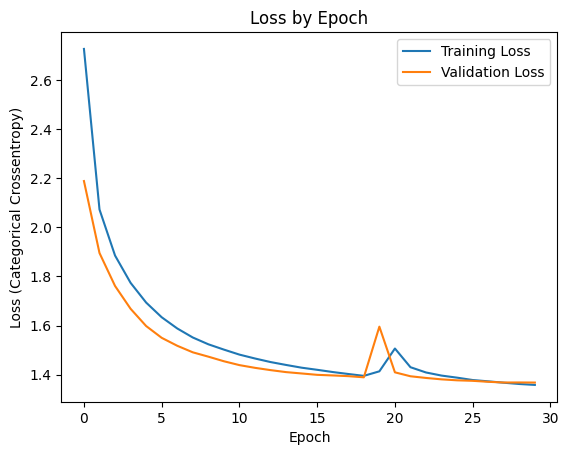

In [18]:
with open(HISTORY_PATH, "rb") as infile:
    history = pickle.load(infile)

print(history.keys())
fig, ax = plt.subplots()
ax.plot(history["loss"], label="Training Loss")
ax.plot(history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Categorical Crossentropy)")
ax.set_title("Loss by Epoch")
ax.legend()

### 3.5 Evaluate the model on the test set

In [19]:
# TODO

### 3.6 Generate a poem

In [20]:
with open(VECTORIZER_PATH, "rb") as infile:
    vectorizer = pickle.load(infile)
print("loaded vectorizer")

model = keras.models.load_model(MODEL_PATH)
print("loaded model")

seed_phrase = "i sing a song of myself "
seed_phrase_chars = list(seed_phrase)

MAX_POEM_LENGTH = 250  # in case we don't encounter a poem boundary character

for i in range(0, MAX_POEM_LENGTH):
    # Vectorize the seed phrase and give it the shape:
    # (batch_size, seq-length, vocab_size)
    vec = (vectorizer
           .tokens_to_vectors(list(seed_phrase_chars))
           .reshape(1, len(seed_phrase_chars), vectorizer.vocab_size()))
    
    # Ask the model for a prediction on the current seed phrase
    pred_distribution = model(vec)[0].numpy()
    
    # Make a choice over the probability distribution, like in the Shannon method
    options = list(range(0, vectorizer.vocab_size()))
    idx = np.random.choice(options, p=pred_distribution)
    
    # Turn the chosen value into a character and append it to the seed
    char = vectorizer.int_to_token(idx)
    seed_phrase_chars.append(char)
    
    # If the character is one of the poem segmenting symbols, end early
    if char in ["@", "$"]:
        break

print("".join(seed_phrase_chars))

loaded vectorizer
loaded model
i sing a song of myself so meaging,
  if wash of mighty best well-know was daughters and his crost-bare;)
  all thought of the tois to behold, crowd not you,
  steel, the true, indisnopels fluhables.)$


## 4. Comparing Generated Poems from N-gram LM and Recurrent Neural LM